# Graph Neural Networks

### Author: [John F. Wu](https://jwuphysics.github.io/)

Presented as a tutorial during [Session 19](https://github.com/LSSTC-DSFP/Session-19) of the [LSSTC Data Science Fellowship Program](https://www.lsstcorporation.org/lincc/fellowship_program).

[![Open this notebook in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/jwuphysics/LSSTC-DSFP-Session-19/blob/main/day4/Graph%20Neural%20Networks.ipynb)


## Introduction

In this tutorial, we will:
0. learn about the basics of mathematic graphs and their ability to represent (astro)physical systems,
1. create a cosmic graph from a catalog of dark matter halo properties,
2. link together neighboring halos on the graph, and
3. optimize a neural network that takes the cosmic graph as input, and outputs the stellar mass for every dark matter halo.


<center><img src="https://ar5iv.labs.arxiv.org/html/2306.12327/assets/figures/cosmic-graph.png" width="500" height="500"></center>

**Figure**: A graph of dark matter halos, colored by their halo masses, in a 50 Mpc volume connected using a linking length of 5 Mpc.



**References**
- [Wu & Jespersen (2023)](https://ui.adsabs.harvard.edu/abs/2023arXiv230612327W/abstract) ICML ML4Astro workshop paper; see also the [halo-gnns](https://github.com/jwuphysics/halo-gnns) repository
- [Nelson et al. (2019)](https://ui.adsabs.harvard.edu/abs/2019ComAC...6....2N/abstract) for the [Illustris TNG300](https://www.tng-project.org/data/) hydrodynamic simulation

**Other Resources**
- [KITP GNN tutorial notebook](https://github.com/DataDrivenGalaxyEvolution/galevo23-tutorials/blob/main/week-3/KITP-CCA-GNN-tutorial.ipynb) and accompanying [recording](https://www.dropbox.com/scl/fo/tgpwe1ljr4i9go4ajnsq6/h?dl=0&preview=2023-02-03++CCA+KITP+-+Tutorial+-+Christian+Kragh+Jespersen+-+Alpha+Beta.mp4&rlkey=mwl1zi14okj5k1pnbflcgnz3l) by Christian Kragh Jespersen
- [Pytorch-Geometric documentation](https://pytorch-geometric.readthedocs.io/en/latest/) and  [tutorials](https://pytorch-geometric.readthedocs.io/en/latest/get_started/colabs.html)
- [Stanford CS224W tutorials](https://medium.com/stanford-cs224w)

## Setting up the notebook

1. (*Optional*) If you want to use a GPU runtime, make sure to set it before getting started. At the top of this page, click on `Runtime` > `Change runtime type` > Under `Hardware accelerate`, select `T4 GPU`. However, note that Colab only allocates a limited amount of GPU time, and that most of this notebook should run in a reasonable amount of time even if you use a CPU instead.
2. Run the **Install Pytorch-Geometric and other necessary packages** cell below in order to install the required Python packages. You can click the triangle "play button" in order to run each cell. If you see a green checkmark to the left of the cell, then it should have successfully installed the packages! (My cell also says 45s below the checkmark, which is the duration of time it took to install the packages.)
3. Run the **Import Python packages** cell in order to be able to use packages like `pytorch`, `pytorch_geometric`, `numpy`, `pandas`, and `matplotlib`.
4. Run the **Download TNG300 simulation data** cell in order to get the subhalo catalogs that have been put together for this tutorial.



In [1]:
#@title Install Pytorch-Geometric and other necessary packages
import torch

def format_pytorch_version(version):
  return version.split('+')[0]

TORCH_version = torch.__version__
TORCH = format_pytorch_version(TORCH_version)

def format_cuda_version(version):
  return 'cu' + version.replace('.', '')

CUDA_version = torch.version.cuda
CUDA = format_cuda_version(CUDA_version)

!pip install torch-scatter -qf https://data.pyg.org/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-sparse -qf https://data.pyg.org/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-cluster -qf https://data.pyg.org/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-spline-conv -qf https://data.pyg.org/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-geometric -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 38.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 13.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 13.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 884.9/884.9 kB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 661.6/661.6 kB 7.7 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [2]:
# @title Import Python packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
import scipy
from sklearn.ensemble import RandomForestRegressor
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.data import Data, Dataset
from torch_geometric.loader import DataLoader, RandomNodeLoader
from torch_geometric.utils import to_networkx, to_undirected
from torch_geometric.nn import (
    MessagePassing, GCNConv, SAGEConv, EdgeConv,
)
from torch_cluster import radius_graph
from tqdm import tqdm


device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [3]:
# @title Download TNG300 simulation data
!wget -q -O subhalos.parquet https://www.dropbox.com/scl/fi/7vng9fx9q6gamu4abomhn/subhalos-hydro.parquet?rlkey=r340qt3ju430qlzkr1t5c7gmy&dl=0

## Exploratory data analysis

It's always nice to get some intuition for what's in the data set. Let's get started by checking the number of rows and columns, and sampling some of the rows.

In [4]:
subhalos = pd.read_parquet("subhalos.parquet")
print(subhalos.shape)
subhalos.sample(5, random_state=42)

(575561, 14)


,halo_id,subhalo_id,subhalo_x,subhalo_y,subhalo_z,subhalo_vx,subhalo_vy,subhalo_vz,subhalo_n_stellar_particles,subhalo_logstellarmass,subhalo_loghalomass,subhalo_logstellarhalfmassradius,subhalo_logvmax,is_central
160037,9686,1410906,257.696960,256.242401,242.047867,-2.273085,-0.876087,-1.755235,302.0,9.382466,11.408699,-0.389048,0.066548,False
91345,1527,819735,116.814217,241.399323,0.567659,-4.636256,-1.159564,4.968324,50.0,8.663425,11.120241,-0.439964,-0.008113,False
268061,66778,2058940,114.273933,197.284836,237.708954,1.258655,-0.427169,1.678606,114.0,8.981591,10.732254,-0.490101,-0.035505,False
26530,105,234190,284.273193,211.680389,269.849518,-1.515295,2.568679,15.666795,1244.0,9.972019,10.446105,-0.419199,0.110724,False
15898,44,138865,254.676071,46.254433,230.594543,-1.381728,2.479295,8.945479,76.0,8.794954,10.250854,-0.266211,-0.180496,False


Since we know that these are all subhalo properties, I'm going to make the column names more concise.

In [5]:
subhalo_colname_mapping = {
    c: c[8:]
    for c in subhalos.columns
    if (c.startswith("subhalo_") and c != "subhalo_id")
}

subhalos.rename(subhalo_colname_mapping, axis=1, inplace=True)

subhalos.sample(5, random_state=42)

,halo_id,subhalo_id,x,y,z,vx,vy,vz,n_stellar_particles,logstellarmass,loghalomass,logstellarhalfmassradius,logvmax,is_central
160037,9686,1410906,257.696960,256.242401,242.047867,-2.273085,-0.876087,-1.755235,302.0,9.382466,11.408699,-0.389048,0.066548,False
91345,1527,819735,116.814217,241.399323,0.567659,-4.636256,-1.159564,4.968324,50.0,8.663425,11.120241,-0.439964,-0.008113,False
268061,66778,2058940,114.273933,197.284836,237.708954,1.258655,-0.427169,1.678606,114.0,8.981591,10.732254,-0.490101,-0.035505,False
26530,105,234190,284.273193,211.680389,269.849518,-1.515295,2.568679,15.666795,1244.0,9.972019,10.446105,-0.419199,0.110724,False
15898,44,138865,254.676071,46.254433,230.594543,-1.381728,2.479295,8.945479,76.0,8.794954,10.250854,-0.266211,-0.180496,False


In [6]:
# another way to look over the data
subhalos.describe()

,halo_id,subhalo_id,x,y,z,vx,vy,vz,n_stellar_particles,logstellarmass,loghalomass,logstellarhalfmassradius,logvmax
count,5.755610e+05,5.755610e+05,575561.000000,575561.000000,575561.000000,575561.000000,575561.000000,575561.000000,5.755610e+05,575561.000000,575561.000000,575561.000000,575561.000000
mean,1.389290e+05,1.897329e+06,149.415933,147.766732,155.047171,-0.001547,-0.001022,0.005073,1.214170e+03,9.082638,11.154798,-0.351442,0.016922
std,1.828380e+05,8.611278e+05,86.071509,85.910207,87.680782,3.289264,3.449081,3.325910,6.150041e+03,0.829037,0.578295,0.159494,0.164010
min,0.000000e+00,0.000000e+00,-0.000138,0.000780,0.000191,-35.227821,-32.990891,-38.735672,1.100000e+01,7.802888,10.002408,-1.084315,-0.465809
25%,6.496000e+03,1.281398e+06,75.306358,73.485962,78.950890,-1.867824,-2.020941,-1.803282,2.700000e+01,8.374451,10.806041,-0.463014,-0.100773
50%,8.238300e+04,2.136519e+06,145.380081,144.840591,157.775726,-0.076896,-0.000151,0.043150,9.700000e+01,8.918050,11.118300,-0.366071,-0.017282
75%,2.185230e+05,2.548314e+06,224.117249,220.416412,230.652252,1.803044,2.004178,1.851016,5.760000e+02,9.671121,11.453988,-0.253483,0.107410
max,2.741910e+06,5.612007e+06,302.627625,302.626892,302.626801,38.109730,36.413002,32.281666,1.019397e+06,12.894207,15.205021,1.642285,1.241579


In [7]:
# some of these positions are negative -- let's make sure they're above 0
subhalos[["x", "y", "z"]] -= subhalos[["x", "y", "z"]].min(0)

Let's get a sense of how the data are distributed from a scientific perspective. But we have over half a million halos! Let's get a smaller sample just for visualization.

In [8]:
# get a smaller subset of rows
df = subhalos[(subhalos.x < 50) & (subhalos.y < 50) & (subhalos.z < 50)].copy()
len(df)

1669

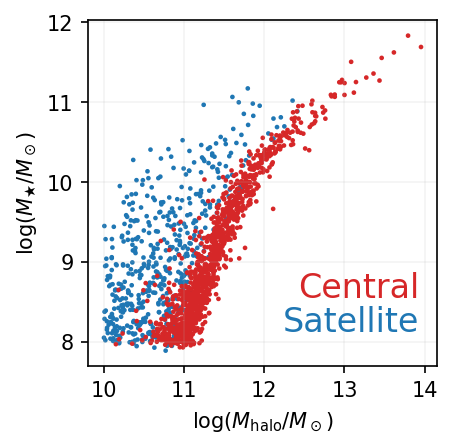

In [9]:
# @title Let's plot the **Stellar mass-Halo mass relation**:
plt.figure(figsize=(3, 3), dpi=150)
plt.scatter(
    x=df["loghalomass"],
    y=df["logstellarmass"],
    s=5,
    c=np.where(df["is_central"], "C3", "C0"),
    edgecolors="none",
)

plt.text(0.95, 0.2, "Central", color="C3", transform=plt.gca().transAxes, ha="right", fontsize=16)
plt.text(0.95, 0.1, "Satellite", color="C0", transform=plt.gca().transAxes, ha="right", fontsize=16)

plt.xlabel(r"$\log(M_{\rm halo}/M_\odot)$")
plt.ylabel(r"$\log(M_\bigstar/M_\odot)$")
plt.grid(alpha=0.15)

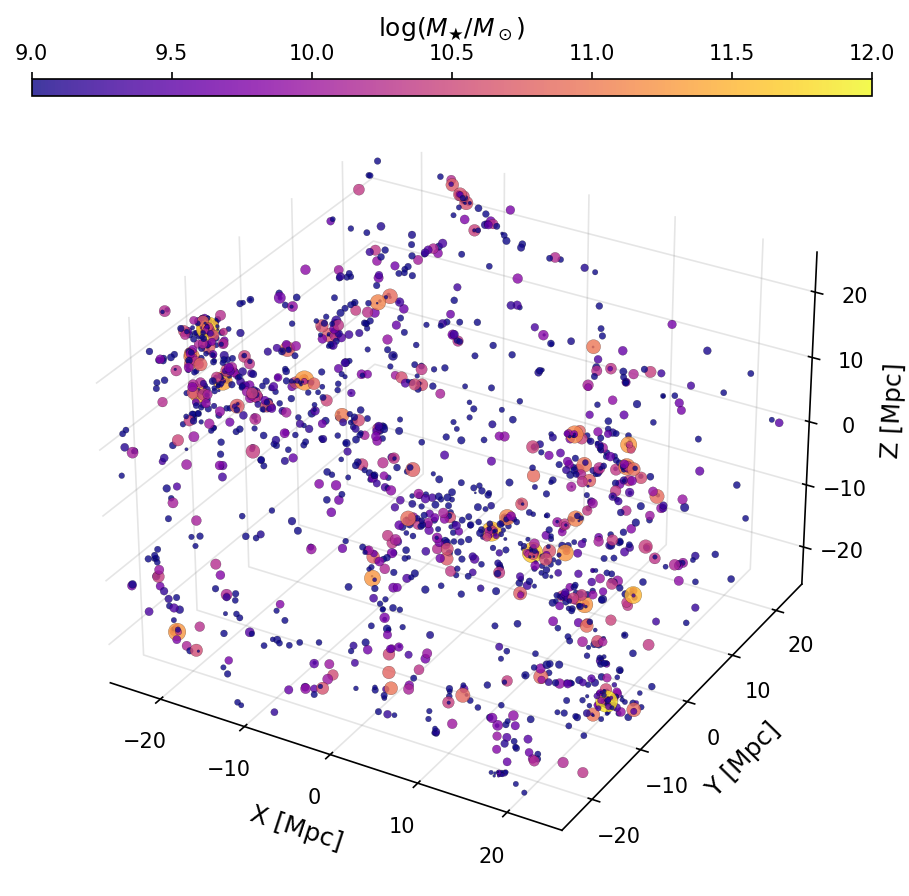

In [10]:
# @title Let's also take a look at the **3d distribution of galaxies/subhalos**:

fig = plt.figure(figsize=(7, 8), dpi=150)
ax = fig.add_subplot(projection="3d")

fontsize = 12
pos = df[["x", "y", "z"]] - 25

# plot nodes
sc = ax.scatter(
    pos.x,
    pos.y,
    pos.z,
    s=(df.loghalomass-9)**3,
    vmin=9,
    vmax=12,
    alpha=0.8,
    edgecolor='k',
    c=df.logstellarmass,
    cmap="plasma",
    linewidths=0.1
)
fig.subplots_adjust(left=0.1, right=0.9)

cb = fig.colorbar(sc, aspect=50, pad=-0.02, location='top')
cb.set_label(r"log($M_\bigstar/M_\odot$)", fontsize=12)

ax.set_xlim(-25, 25)
ax.set_ylim(-25, 25)
ax.set_zlim(-25, 25)
ax.set_xlabel("X [Mpc]", fontsize=12)
ax.set_ylabel("Y [Mpc]", fontsize=12)
ax.set_zlabel("Z [Mpc]", fontsize=12)
ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.xaxis._axinfo["grid"]['color'] =  (0.5,0.5,0.5,0.2)
ax.yaxis._axinfo["grid"]['color'] =  (0.5,0.5,0.5,0.2)
ax.zaxis._axinfo["grid"]['color'] =  (0.5,0.5,0.5,0.2)

## Mathematical graphs

This last plot shows the positions of subhalos in the TNG300 catalog. These data sets are sometimes called "point clouds" in computer vision, and they will serve as the launching point for our foray into graphs and graph neural networks.

Graphs can be represented in many ways, but here we will focus on implementing them in PyG ([`torch_geometric.data.Data`](https://pytorch-geometric.readthedocs.io/en/stable/generated/torch_geometric.data.Data.html#torch_geometric.data.Data)). This `Data` class is a flexible way to store graphs and general features (aka *attributes*). Let's look at the following graph:

In [15]:
x = torch.tensor([[2.5], [4.5], [1.7], [1.0]], dtype=torch.float)

edge_index = torch.tensor([[0, 1, 1, 2, 1, 3],
                           [1, 0, 2, 1, 3, 1]], dtype=torch.long)

data = Data(x=x, edge_index=edge_index)

print(data)

Data(x=[4, 1], edge_index=[2, 6])


First, let's look at how the graph is connected via the `data.edge_index` attribute. We'll check out the other attribute, `data.x` (which holds the node features) in a moment.

The `edge_index` is a *sparse* representation of a graph's adjacency matrix, $\mathbf{A}$. The connectivity of the above graph can be described by its adjacency matrix:

$$ \mathbf{A} =
\begin{pmatrix}
0 & 1 & 0 & 0 \\
1 & 0 & 1 & 1 \\
0 & 1 & 0 & 0 \\
0 & 1 & 0 & 0
\end{pmatrix}$$

or equivalently, the `edge_index` representation that we wrote above:

```python
edge_index = torch.tensor([[0, 1, 1, 2, 1, 3],
                           [1, 0, 2, 1, 3, 1]], dtype=torch.long)
```

We can make note of several properties already:
1. The elements of the adjacency matrix $\mathbf{A}_{ij}$ between nodes $i$ and $j$ are 1 if an edge exists, and 0 if an edge doesn't exist between the two nodes.
2. The number of non-zero elements in $\mathbf{A}$ is equal to the length of a row in `edge_index`.
3. The above graph is an *undirected* (aka *bidirected*) graph. As a result, its adjacency matrix $\mathbf{A}$ is symmetric.
4. If the graph has $\mathcal{V}$ nodes and $\mathcal{E}$ *directed* edges, then the graph is sparse when $\mathcal{E} \ll \mathcal{V}^2$. In such cases, the `edge_index` representation (requiring $2 \times \mathcal{E}$ elements) is more efficient than writing out the entire adjacency matrix.
5. None of the nodes connect to themselves, and therefore the diagonal of $\mathbf{A}$ is all zeros. If the graph contains *self-loops*, then those diagonal elements would contain ones.
6. Everything is 0-indexed here because we're using Python. Note that in mathematics we conventionally see 1-indexing.

We can use another package, `networkx`, to make basic visualizations of these graphs. In this case, we are drawing the $\mathcal{V} = 4$ nodes and the $\mathcal{E} = 6$ directed edges. We are also scaling each node's size by its (single) feature stored in `data.x`.

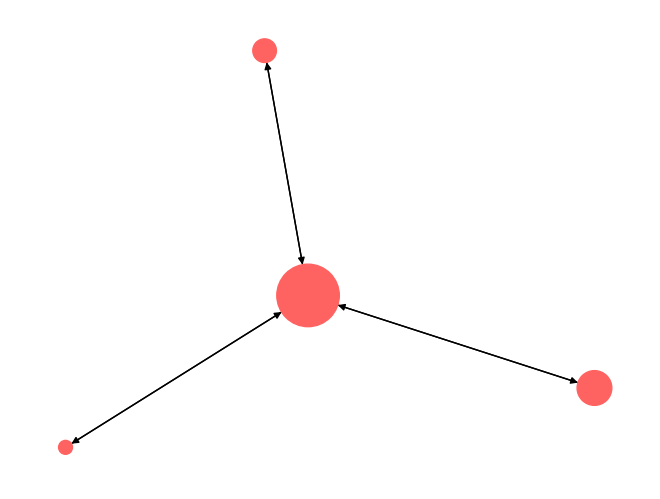

In [23]:
nxGraph = to_networkx(data)
nx.draw(nxGraph, node_size=(10*data.x)**2, node_color="#ff6361")

### **Exercise 1**
**What is the index of the node that connects to the other three nodes?**


<details>
<summary><b>Answer</b></summary>
  
The node indexed to `1` is connected to the other nodes. You can verify corresponding row and column in the adjacency matrix $\mathbf{A}_{i1}$ and $\mathbf{A}_{1j}^T$ are $(1, 0, 1, 1)$, signifying that the node has undirected edges connecting to the other three nodes.

One way to visualize this is to run the following code
```python
nxGraph = to_networkx(data)
nx.draw(nxGraph, node_size=(10*data.x)**2, node_color="#ff6361", with_labels=True)
```
  
We can also verify that the node feature at the index `1` has the largest value, in accordance with the graph plotted above. By running
```python
for V_i, x_i in enumerate(data.x):
    print(f"Node {V_i}: x = {x_i.item():g}")
```
or by looking back to the constructor for `data`, we can see that the node feature at `data.x[1]` has the largest value.

</details>

### **Exercise 2**

**Create another `torch_geometric.data.Data` object with the same nodes and edge features as above, but also with self-loops.**

<details>
<summary><b>Answer</b></summary>
  
We can construct a new versions of `edge_index` with the self-loops:
```python
edge_index = torch.tensor([[0, 1, 1, 2, 1, 3, 0, 1, 2, 3],
                           [1, 0, 2, 1, 3, 1, 0, 1, 2, 3]], dtype=torch.long)
```
Since the node features remain the same, we don't need to update that. However, we do need to remake the PyG `Data` object, and we can optionally plot it again:
```python
data = Data(x=x, edge_index=edge_index)

nxGraph = to_networkx(data)
nx.draw(nxGraph, node_size=(10*data.x)**2)
```

Another solution is to use [`torch_geometric.utils.add_self_loops`](https://pytorch-geometric.readthedocs.io/en/latest/modules/utils.html#torch_geometric.utils.add_self_loops), which takes in the `edge_index` and an optional `edge_weight`, and returns the output `edge_index` and `edge_weight`.

If we ran it here, we'd find:
```python
from torch_geomegtric.utils import add_self_loops
edge_index, _ = add_self_loops(edge_index)
print(edge_index)

> (tensor([[0, 1, 1, 2, 1, 3, 0, 1, 2, 3],
>         [1, 0, 2, 1, 3, 1, 0, 1, 2, 3]]),
> None)
```

</details>

### **Exercise 3**

**Fill in the `data.edge_index` attribute to connect all nodes (minus self-loops) the graph shown below.**

Note that a graph without self-loops is called a *simple graph*, and a fully connected simple undirected graph is called a *complete graph*.

Hint: You may recall that a complete graph with $\mathcal{V}$ nodes will have $\mathcal{V}(\mathcal{V}-1)/2$ undirected edges, but using PyG we need to specify both directions for the edges!


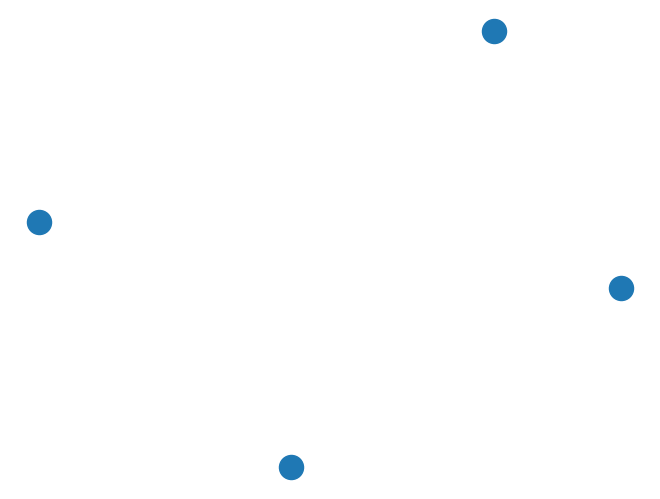

In [ ]:
# add indices below
edge_index = torch.tensor([[], []], dtype=torch.long)

# just stick random entries below
x_features = torch.randn((4, 1))

data = Data(edge_index=edge_index, x=x_features)

nxGraph = to_networkx(data)
nx.draw(nxGraph)

<details>
<summary><b>Answer</b></summary>
  
One solution is to write out all of the indices, e.g.,

```python
edge_index = torch.tensor([[1, 2, 3, 2, 3, 3, 0, 1, 2, 0, 1, 0],
                           [0, 1, 2, 0, 1, 0, 1, 2, 3, 2, 3, 3]], dtype=torch.long)
```

Another solution is to write out half of these edges, and then use the helper function [`torch.utils.to_undirected`](https://pytorch-geometric.readthedocs.io/en/latest/modules/utils.html#torch_geometric.utils.to_undirected) like such:
```python
from torch_geometric.utils import to_undirected

edge_index = torch.tensor([[1, 2, 3, 2, 3, 3],
                           [0, 1, 2, 0, 1, 0]], dtype=torch.long)
edge_index = to_undirected(edge_index)
```

Finally we can construct our `Data` object, and plot it:
```python
x_features = torch.randn((4,1))

data = Data(edge_index=edge_index, x=x_features)

nxGraph = to_networkx(data)
nx.draw(nxGraph)
```
</details>

### Some final technical notes
* We are writing out the edge indices by specifying all of the $i$ indices, and then all of the $j$ indices. It is also possible to write out a tensor of $(i, j)$ indices, and then transpose that tensor. However, we must ensure that this representation is *contiguous* in memory, e.g.:

    ```python
  x = torch.tensor([[-1], [0], [1]], dtype=torch.float)

  edge_index = torch.tensor([[0, 1],
                             [1, 0],
                             [1, 2],
                             [2, 1]], dtype=torch.long)

  data = Data(x=x, edge_index=edge_index.t().contiguous())
    ```
* For indices and other integer-typed attributes, make sure you specify the data type as `dtype=torch.long`.
* This tutorial only focuses on homogeneous graphs, i.e., all of the nodes correspond to galaxies/subhalos, and all edges encode relationships between them. However, it's possible to build graphs with heterogeneous nodes or edges. For example, the Atacama Large Millimeter/submillimeter Array (ALMA) comprises both 7-m and 12-m antennas (see below); they could be represented on [*heterogeneous graphs*](https://pytorch-geometric.readthedocs.io/en/latest/notes/heterogeneous.html?highlight=heterogeneous).
<center><img src="https://www.almaobservatory.org/wp-content/uploads/2023/05/file-1-copy-2048x988.jpeg" width="600"></center>


## Building a cosmic graph using PyG

In [11]:
# select a smaller subset of subhalos that are better resolved by the simulation
cut = subhalos["loghalomass"] > 11

df = subhalos[cut].copy()

In [12]:
# get input node features, `x`, and targets, `y`
x = torch.tensor(df[["loghalomass", "logvmax"]].values, dtype=torch.float)
y = torch.tensor(df[["logstellarmass"]].values, dtype=torch.float)

# also keep track of positions
pos = torch.tensor(df[["x", "y", "z"]].values, dtype=torch.float)

In [13]:
D_link = 5

# get all edges
kd_tree = scipy.spatial.KDTree(pos, leafsize=25, boxsize=205.0001/0.6774)
edge_index = kd_tree.query_pairs(r=D_link, output_type="ndarray")

# use tensor, add reverse pairs
edge_index = torch.Tensor(edge_index).t().contiguous().type(torch.long)
edge_index = to_undirected(edge_index)

In [14]:
# compute distances and velocity differences between pairwise node combinations
row, col = edge_index
dist = torch.tensor(np.linalg.norm(pos[row] - pos[col], axis=1)).reshape(-1, 1)

vel = torch.tensor(df[["vx", "vy", "vz"]].values, dtype=torch.float)
veldiff = torch.tensor(np.linalg.norm(vel[row] - vel[col], axis=1)).reshape(-1, 1)

edge_attr = torch.cat([dist, veldiff], dim=-1).type(torch.float)

In [15]:
data = Data(
    x=x,
    y=y,
    pos=pos,
    edge_index=edge_index,
    edge_attr=edge_attr,
)

In [16]:
data

Data(x=[352738, 2], edge_index=[2, 8022520], edge_attr=[8022520, 2], y=[352738, 1], pos=[352738, 3])

## Setting up the problem: Predict $M_\star$ from $M_{\rm halo}$ with GNNs

In [17]:
# a smaller subset of the full data
train_mask = (df["z"] <= 200) & (df["x"] < 50) & (df["y"] < 50)
valid_mask = (df["z"] > 210) & (df["x"] < 50) & (df["y"] < 50)

# note -- this is the equivalent of `np.argwhere()`
train_indices = torch.tensor(train_mask.values).nonzero(as_tuple=True)[0]
valid_indices = torch.tensor(valid_mask.values).nonzero(as_tuple=True)[0]

assert (set(train_indices) & set(valid_indices)) == set()

## Train a baseline model

In this case, we will train a [`scikit-learn` Random Forest (RF) regression model](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html#sklearn.ensemble.RandomForestRegressor). Refer back to Viviana's lectures for details on decision tree-based algorithms!

In [18]:
# train-test split
df_train = df[train_mask].copy()
df_valid = df[valid_mask].copy()

X_train = df_train[["loghalomass", "logvmax"]].values
y_train = df_train[["logstellarmass"]].values
X_valid = df_valid[["loghalomass", "logvmax"]].values
y_valid = df_valid[["logstellarmass"]].values

In [22]:
# random forest <3
rf = RandomForestRegressor(n_estimators=25, random_state=42)
rf.fit(X_train, y_train.ravel())
p_valid = rf.predict(X_valid)

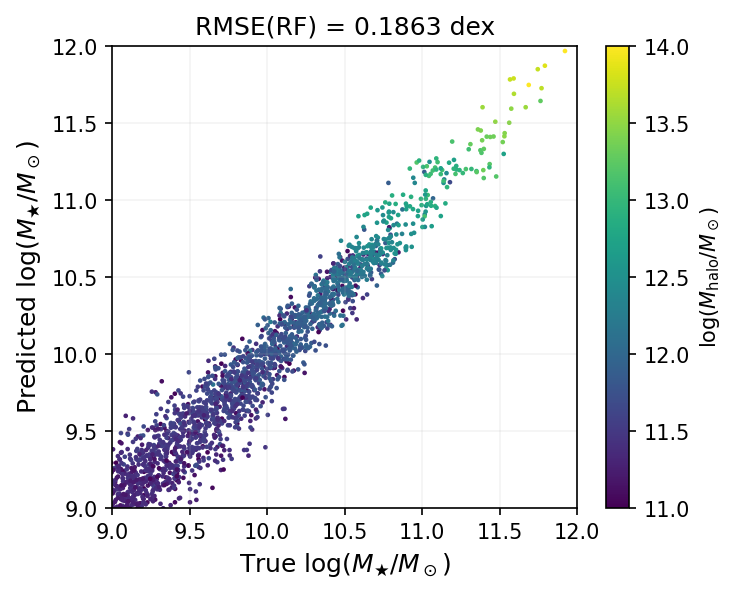

In [23]:
plt.figure(figsize=(5, 4), dpi=150)
plt.scatter(y_valid, p_valid, s=5, edgecolors="none", c=df_valid.loghalomass.values, vmin=11, vmax=14)
plt.colorbar(label=r"$\log(M_{\rm halo}/M_\odot)$")
plt.grid(alpha=0.15)
plt.xlim(9, 12)
plt.ylim(9, 12)
plt.xlabel(r"True $\log(M_\bigstar/M_\odot)$", fontsize=12)
plt.ylabel(r"Predicted $\log(M_\bigstar/M_\odot)$", fontsize=12)

plt.title(f"RMSE(RF) = {((p_valid.ravel() - y_valid.ravel())**2).mean()**0.5:.4f} dex");

## Creating a simple graph neural network

This network uses SAGEConv (or GraphSAGE), which uses node-only features and the graph connectivity. In other words, the subhalos know about their own and neighboring subhalos' masses, but nothing about positional or velocity differences between it and its neighbors. See the paper by [Hamilton et al. (2017)](https://arxiv.org/abs/1706.02216) for more details.

In [44]:
class SAGEGraphConvNet(torch.nn.Module):
    """A simple GNN built using SAGEConv layers.
    """
    def __init__(self, n_in=2, n_hidden=128, n_out=1):
        super(SAGEGraphConvNet, self).__init__()
        self.conv1 = SAGEConv(n_in, n_hidden)
        self.conv2 = SAGEConv(n_hidden, n_hidden)
        self.fc = nn.Linear(n_hidden, n_out, bias=True)
        self.mlp = nn.Sequential(
            nn.Linear(n_in, n_hidden, bias=True),
            nn.ReLU(),
            nn.LayerNorm(n_hidden),
            nn.Linear(n_hidden, n_out, bias=True)
        )

    def forward(self, data):
        x0, edge_index = data.x, data.edge_index

        x1 = self.conv1(x0, edge_index)
        x2 = self.conv2(F.relu(x1), edge_index)
        convs_out = self.fc(F.relu(x2))
        mlp_out = self.mlp(x0)
        return convs_out + mlp_out

In [45]:
model = SAGEGraphConvNet().to(device)

### **Exercise 4**

**What are the dimensions of the inputs and outputs for each layer in the initialized model (`conv1`, `conv2`, `fc`, and `mlp`)?**



<details>
<summary><b>Answer</b></summary>

All of the layers are two-dimensions, with the first dimension equal to the batch size, which I'll call `bs`.

For `conv1`: The inputs are of shape `(bs, 2)` since there are two node features. The outputs are of shape `(bs, 128)`, since `n_hidden = 128` when we initialized the model.

For `conv2`: The intputs are now shape `(bs, 128)` since it takes the outputs of the previous layer (after applying a rectified linear unit, or ReLU). The output is again `(bs, 128)`.

For `fc`: The inputs have shape `(bs, 128)` since it receives the previous layer's output. The output has shape `(bs, 1)`.

For `mlp`: The inputs have shape `(bs, 2)`, as it ingests the node-level features as inputs. There is a hidden layer, non-linear activation, and normalization layer, and finally the output is of shape `(bs, 1)`.

</details>

### **Exercise 5**

**Modify the SAGEGraphConvNet in the following way:**


1. **Remove the `fc` layer**.
2. **Adjust the `mlp` layer such that it ingests both the node input features, as well as the activated outputs of `conv2`**.

*Hint: for part two, you'll need to concatenate the features using `torch.cat()` along the last dimension.*



<details>
<summary><b>Answer</b></summary>

One solution is like such:

```python
class SAGEGraphConvNet(torch.nn.Module):
    """A simple GNN built using SAGEConv layers.
    """
    def __init__(self, n_in=2, n_hidden=16, n_out=1):
        super(SAGEGraphConvNet, self).__init__()
        self.conv1 = SAGEConv(n_in, n_hidden)
        self.conv2 = SAGEConv(n_hidden, n_hidden)
        self.mlp = nn.Sequential(
            nn.Linear(n_in + n_hidden, n_hidden, bias=True),
            nn.ReLU(),
            nn.LayerNorm(n_hidden),
            nn.Linear(n_hidden, n_out, bias=True)
        )

    def forward(self, data):
        x0, edge_index = data.x, data.edge_index

        x1 = self.conv1(x0, edge_index)
        x2 = self.conv2(F.relu(x1), edge_index)
        return self.mlp(torch.cat([F.relu(x2), x0], dim=-1))
```
</details>

In [46]:
def train(dataloader, model, optimizer, device="cuda"):

    model.train()

    loss_total = 0
    for data in dataloader:
        data.to(device)

        optimizer.zero_grad()
        y_pred = model(data)
        loss = F.mse_loss(y_pred, data.y)

        loss.backward()
        optimizer.step()
        loss_total += loss.item()

    return loss_total / len(dataloader)

def validate(dataloader, model, device="cuda"):
    model.eval()

    uncertainties = []
    loss_total = 0

    y_preds = []
    y_trues = []

    for data in dataloader:
        with torch.no_grad():
            data.to(device)
            y_pred = model(data)
            loss = F.mse_loss(y_pred, data.y)

            loss_total += loss.item()
            y_preds += list(y_pred.detach().cpu().numpy())
            y_trues += list(data.y.detach().cpu().numpy())

    y_preds = np.concatenate(y_preds)
    y_trues = np.array(y_trues)

    return (
        loss_total / len(dataloader),
        y_preds,
        y_trues,
    )

In [47]:
bs = 256
lr = 1e-2

n_epochs = 100

optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=lr,
)

train_loader = RandomNodeLoader(
    data.subgraph(train_indices),
    num_parts=(len(train_indices) // bs),
    shuffle=True
)

valid_loader = RandomNodeLoader(
    data.subgraph(valid_indices),
    num_parts=(len(valid_indices) // bs),
    shuffle=False
)


In [48]:
train_losses = []
valid_losses = []

print(f"Epoch    Train loss   Valid Loss      RSME ")
for epoch in range(n_epochs):

    train_loss = train(train_loader, model, optimizer, device=device)
    valid_loss, p, y  = validate(valid_loader, model, device=device)

    print(f" {epoch + 1: >4d}    {train_loss: >9.5f}    {valid_loss: >9.5f}    {np.sqrt(np.mean((p - y.flatten())**2)): >10.6f}")
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)

Epoch    Train loss   Valid Loss      RSME 
    1     10.78090      1.00738      1.003836
    2      0.72725      0.50603      0.710329
    3      0.47967      0.42042      0.648104
    4      0.39608      0.35147      0.592199
    5      0.31097      0.24942      0.498998
    6      0.19152      0.13286      0.364119
    7      0.09504      0.06844      0.261623
    8      0.06004      0.04823      0.219641
    9      0.05077      0.04628      0.215137
   10      0.05254      0.04243      0.205948
   11      0.04976      0.04484      0.211671
   12      0.04738      0.04321      0.207802
   13      0.04575      0.04014      0.200327
   14      0.04666      0.04658      0.215734
   15      0.05012      0.04712      0.217114
   16      0.04545      0.03919      0.197956
   17      0.04543      0.03897      0.197373
   18      0.04575      0.03905      0.197611
   19      0.04456      0.04054      0.201307
   20      0.04285      0.03764      0.193977
   21      0.04295      0.03771     

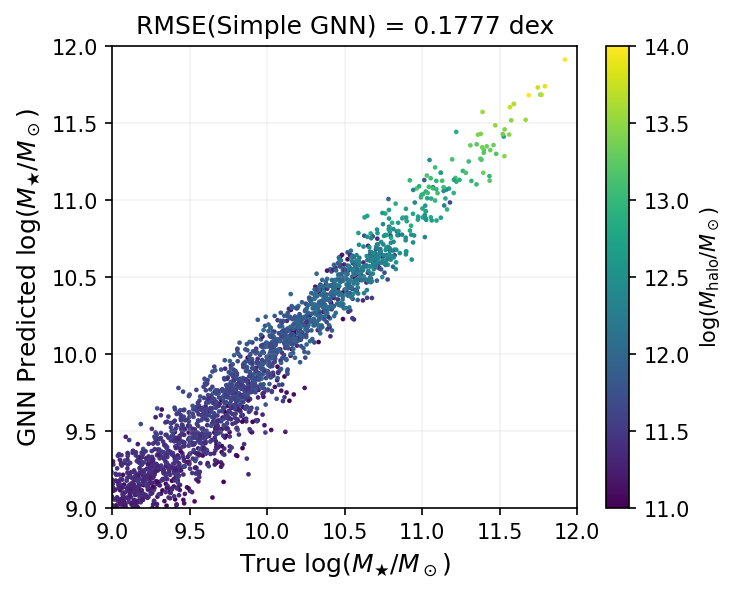

In [49]:
valid_loss, p, y  = validate(valid_loader, model, device=device)

plt.figure(figsize=(5, 4), dpi=150)
plt.scatter(y, p, s=5, edgecolors="none", c=df.iloc[valid_indices].loghalomass.values, vmin=11, vmax=14)
plt.colorbar(label=r"$\log(M_{\rm halo}/M_\odot)$")
plt.grid(alpha=0.15)
plt.xlim(9, 12)
plt.ylim(9, 12)
plt.xlabel(r"True $\log(M_\bigstar/M_\odot)$", fontsize=12)
plt.ylabel(r"GNN Predicted $\log(M_\bigstar/M_\odot)$", fontsize=12)

plt.title(f"RMSE(Simple GNN) = {((p.ravel() - y.ravel())**2).mean()**0.5:.4f} dex");

There are many things to vary here in order to help build intuition, for example:
- `SAGEConv` allows you to change the aggregation function from the default of `mean` pooling to anything else.
- What happenes when you change the number of hidden layers in the network?
- What happens when you increase or decrease the batch size?
- How do these hyperparameters (qualitatively) covary with each other?

## Bonus! A far more complicated GNN with edge features and node-edge interactions

Check out the GNN implemented below, which is based on the one from the [Wu & Jespersen (2023)](https://arxiv.org/abs/2306.12327) paper. Can you sketch out the architecture based on the code?

In [56]:
class EdgeInteractionLayer(MessagePassing):
    """Interaction network layer with node + edge layers.
    """
    def __init__(self, n_in, n_hidden, n_latent, aggr='sum'):
        super(EdgeInteractionLayer, self).__init__(aggr)

        self.mlp = nn.Sequential(
            nn.Linear(n_in, n_hidden, bias=True),
            nn.LayerNorm(n_hidden),
            nn.ReLU(),
            nn.Linear(n_hidden, n_hidden, bias=True),
            nn.LayerNorm(n_hidden),
            nn.ReLU(),
            nn.Linear(n_hidden, n_latent, bias=True),
        )

        self.messages = 0.
        self.input = 0.

    def forward(self, x, edge_index, edge_attr):
        return self.propagate(edge_index, x=x, edge_attr=edge_attr)

    def message(self, x_i, x_j, edge_attr):

        self.input = torch.cat([x_i, x_j, edge_attr], dim=-1)
        self.messages = self.mlp(self.input)

        return self.messages

class EdgeInteractionGNN(nn.Module):
    """Graph net over nodes and edges with multiple unshared layers, and sequential layers with residual connections.
    Self-loops also get their own MLP (i.e. galaxy-halo connection).
    """
    def __init__(self, n_layers, D_link, node_features=2, edge_features=2, hidden_channels=16, aggr="sum", latent_channels=16, n_out=1, n_unshared_layers=8, loop=True, use_global_pooling=True):
        super(EdgeInteractionGNN, self).__init__()

        self.n_in = 2 * node_features + edge_features
        self.n_out = n_out
        self.use_global_pooling = use_global_pooling

        layers = [
            nn.ModuleList([
                EdgeInteractionLayer(self.n_in, hidden_channels, latent_channels, aggr=aggr)
                for _ in range(n_unshared_layers)
            ])
        ]
        for _ in range(n_layers-1):
            layers += [
                nn.ModuleList([
                    EdgeInteractionLayer(2 * latent_channels * n_unshared_layers + node_features, hidden_channels, latent_channels, aggr=aggr)
                    for _ in range(n_unshared_layers)
                ])
            ]

        self.layers = nn.ModuleList(layers)

        n_pool = (len(aggr) if isinstance(aggr, list) else 1)
        self.fc = nn.Sequential(
            nn.Linear((n_unshared_layers * n_pool) * latent_channels, latent_channels, bias=True),
            nn.LayerNorm(latent_channels),
            nn.ReLU(),
            nn.Linear(latent_channels, latent_channels, bias=True),
            nn.LayerNorm(latent_channels),
            nn.ReLU(),
            nn.Linear(latent_channels, latent_channels, bias=True)
        )

        self.galaxy_halo_mlp = nn.Sequential(
            nn.Linear(latent_channels + node_features, latent_channels, bias=True),
            nn.LayerNorm(latent_channels),
            nn.ReLU(),
            nn.Linear(latent_channels, latent_channels, bias=True),
            nn.LayerNorm(latent_channels),
            nn.ReLU(),
            nn.Linear(latent_channels, n_out, bias=True)
        )

        self.D_link = D_link
        self.h = 0.

    def forward(self, data):
        edge_index = data.edge_index
        edge_attr = data.edge_attr

        # update hidden state on edge (h, or sometimes e_ij in the text)
        h = torch.cat([unshared_layer(data.x, edge_index=edge_index, edge_attr=edge_attr) for unshared_layer in self.layers[0]], axis=1)
        self.h = h
        h = h.relu()

        for layer in self.layers[1:]:
            # if more than 1 layer, then also use a skip connection
            h = self.h + torch.cat([unshared_layer(h, edge_index=edge_index, edge_attr=edge_attr) for unshared_layer in layer], axis=1)

            self.h = h
            h = h.relu()

        x = torch.concat([self.fc(h), data.x], axis=1) # latent channels + data.x

        return (self.galaxy_halo_mlp(x))

In [85]:
node_features = data.x.shape[1]
edge_features = data.edge_attr.shape[1]


bs = 256
lr = 3e-2

n_epochs = 100

n_layers = 1
n_hidden_channels = 32
n_latent_channels = 32
n_unshared_layers = 8

model = EdgeInteractionGNN(
    node_features=node_features,
    edge_features=edge_features,
    n_layers=n_layers,
    D_link=D_link,
    hidden_channels=n_hidden_channels,
    latent_channels=n_latent_channels,
    loop=True,
    n_unshared_layers=n_unshared_layers,
    n_out=1,
    aggr="sum"
)
model.to(device);

In [86]:
optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=lr,
)

train_loader = RandomNodeLoader(
    data.subgraph(train_indices),
    num_parts=(len(train_indices) // bs),
    shuffle=True
)

valid_loader = RandomNodeLoader(
    data.subgraph(valid_indices),
    num_parts=(len(valid_indices) // bs),
    shuffle=False
)

In [87]:
train_losses = []
valid_losses = []

print(f"Epoch    Train loss   Valid Loss      RSME ")
for epoch in range(n_epochs):

    # anneal learning rate
    if epoch == int(n_epochs * 0.5):
        optimizer = torch.optim.AdamW(
            model.parameters(),
            lr=lr / 10,
        )
    elif epoch == int(n_epochs * 0.9):
        optimizer = torch.optim.AdamW(
            model.parameters(),
            lr=lr / 100,
        )

    train_loss = train(train_loader, model, optimizer, device=device)
    valid_loss, p, y  = validate(valid_loader, model, device=device)

    print(f" {epoch + 1: >4d}    {train_loss: >9.5f}    {valid_loss: >9.5f}    {np.sqrt(np.mean((p - y.flatten())**2)): >10.6f}")
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)

Epoch    Train loss   Valid Loss      RSME 
    1     16.64772      1.14827      1.069715
    2      0.76306      0.68769      0.829084
    3      0.67829      0.65954      0.811783
    4      0.66238      0.64528      0.802554
    5      0.65736      0.65753      0.809958
    6      0.66831      0.64642      0.803683
    7      0.62894      0.49889      0.706211
    8      0.50950      0.39181      0.625303
    9      0.45973      0.27659      0.525803
   10      0.36143      0.20450      0.451525
   11      0.33164      0.16817      0.409866
   12      0.29448      0.13766      0.370463
   13      0.18112      0.08702      0.294716
   14      0.06016      0.04896      0.221331
   15      0.03768      0.03189      0.178567
   16      0.03819      0.03154      0.177577
   17      0.03412      0.03084      0.175578
   18      0.03208      0.03199      0.178853
   19      0.03149      0.03221      0.179444
   20      0.03214      0.03243      0.180062
   21      0.03565      0.03004     

Text(0.5, 1.0, 'Loss curves')

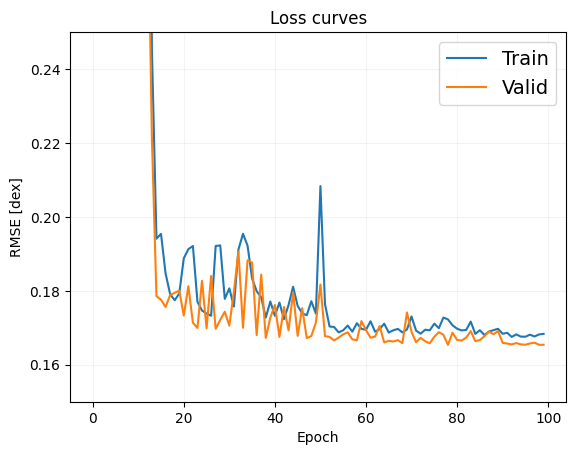

In [88]:
plt.plot(np.sqrt(train_losses), label="Train")
plt.plot(np.sqrt(valid_losses), label="Valid")
plt.xlabel("Epoch")
plt.ylabel("RMSE [dex]")
plt.legend(fontsize=14)
plt.grid(alpha=0.15)
plt.ylim(0.15, 0.25)
plt.title("Loss curves")

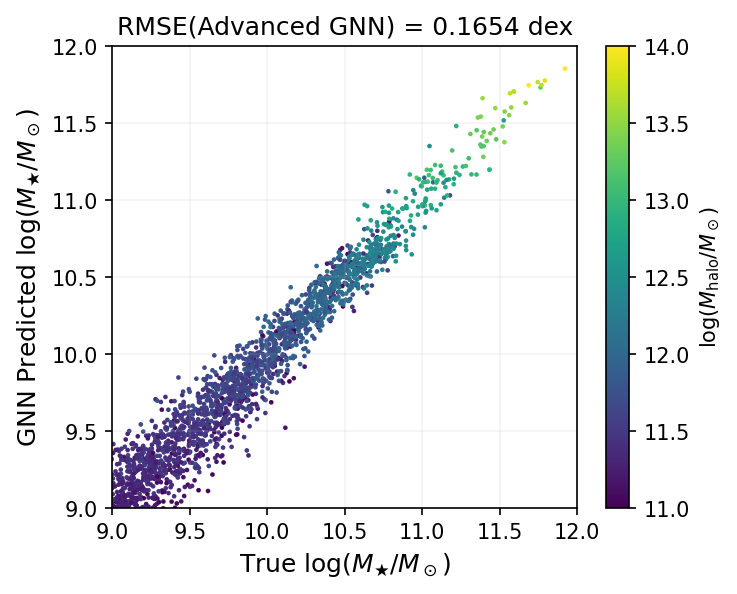

In [89]:
valid_loss, p, y  = validate(valid_loader, model, device=device)

plt.figure(figsize=(5, 4), dpi=150)
plt.scatter(y, p, s=5, edgecolors="none", c=df.iloc[valid_indices].loghalomass.values, vmin=11, vmax=14)
plt.colorbar(label=r"$\log(M_{\rm halo}/M_\odot)$")
plt.grid(alpha=0.15)
plt.xlim(9, 12)
plt.ylim(9, 12)
plt.xlabel(r"True $\log(M_\bigstar/M_\odot)$", fontsize=12)
plt.ylabel(r"GNN Predicted $\log(M_\bigstar/M_\odot)$", fontsize=12)

plt.title(f"RMSE(Advanced GNN) = {((p.ravel() - y.ravel())**2).mean()**0.5:.4f} dex");

### **Exercse 6**
**Add random noise to features during training. Does it help?**

Rationale: Injecting a small amount of random noise to the node and edge features can help the model learn a more robust representation. This method is sometimes called *noise augmentation* or *noise regularization*.

<details>
<summary><b>Answer</b></summary>

Add the following lines to the `train()` train after loading each batch of data:

```python
if augment:
    data_node_features_scatter = 1e-3 * torch.randn_like(data.x) * torch.std(data.x, dim=0)
    data_edge_features_scatter = 1e-3 * torch.randn_like(data.edge_attr) * torch.std(data.edge_attr, dim=0)

    data.x += data_node_features_scatter
    data.edge_attr += data_edge_features_scatter
```

This also introduces another hyperparameter, that is, the scale of noise added during training time. Here I chose `1e-3`, but you may find that other values are better.
</details>

### **Exercise X**

**Design a heterogeneous dataset and graph network that learns different relationships for *central* and *satellite* subhalos.**

Sorry, no solution here. This would be an interesting research problem though!